In [71]:
#Manejo de datos
import pandas as pd
import numpy as np

#Preprocesamiento de entrenamiento y prueba
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score



# Para menejo de PLN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD

#Modelado y metricas
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

#Gráficas
import matplotlib.pyplot as plt

#Quitar avisos molestos
import warnings
from sklearn.exceptions import FitFailedWarning

# Ignorar ciertas advertencias
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*') 

In [72]:
#Leer la base de datos
df = pd.read_excel("textos.xlsx")

In [73]:
#Filtrar por tipo de texto 1
df = df[df["ESTADO"]==1]

In [74]:
#Descargar los stop words convencionales de nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57350\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
#Definir una función que reprocese los textos
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('spanish'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [76]:
#Se guardan los textos reprocesados
df['TEXTO2'] = df['TEXTO'].apply(preprocess_text)

In [77]:
#Se definen los conjuntos de entrnamiento y test
y = df['ESTADO']
X_train, X_test, y_train, y_test = train_test_split(df['TEXTO2'], y, test_size=0.1, random_state=53)

In [78]:
# Vectorización con CountVectorizer
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


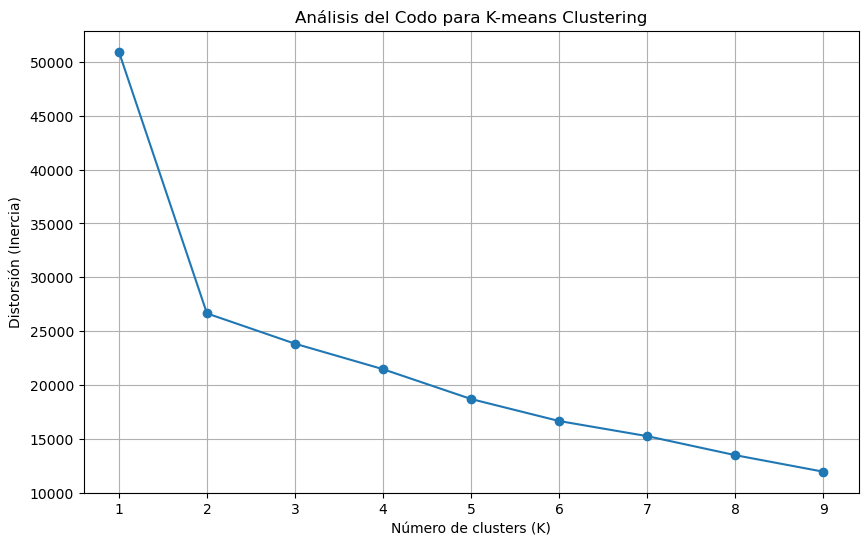

In [79]:
# Rango de valores de K que queremos probar
K_range = range(1, 10)  # Por ejemplo, de 1 a 10

distortions = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(count_train)
    distortions.append(kmeans.inertia_)  # inercia: Suma de distancias al cuadrado al centro más cercano

    
plt.figure(figsize=(10, 6))
plt.plot(K_range, distortions, marker='o')
plt.title('Análisis del Codo para K-means Clustering')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Distorsión (Inercia)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


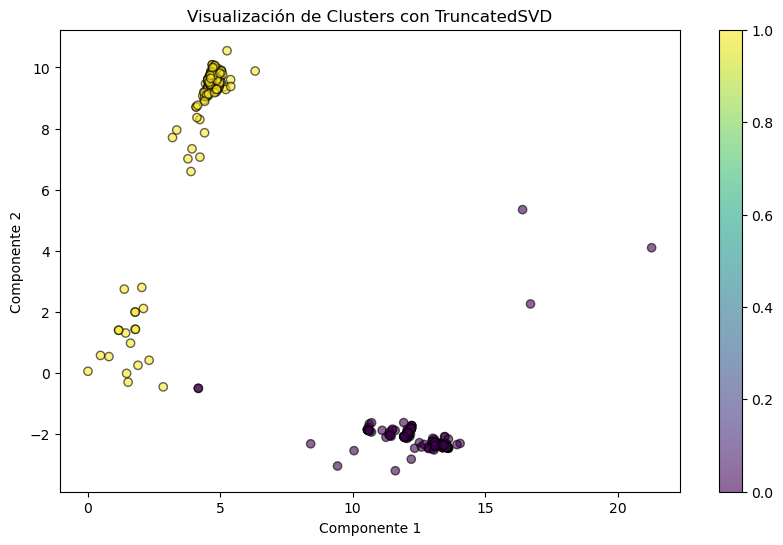

In [101]:
# Instanciar TruncatedSVD con 2 componentes
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_data = svd.fit_transform(count_train)  # Reducción de dimensionalidad

# Realizar el clustering con K-means
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Gráfico de dispersión de los clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', edgecolor='k', alpha=0.6)
plt.title('Visualización de Clusters con TruncatedSVD')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar()
plt.show()

In [102]:
kmeans = KMeans(n_clusters=2, random_state=53)

# Ajustar el modelo a los datos de entrenamiento vectorizados
kmeans.fit(reduced_data)

svd.fit_transform(reduced_data)

# Predecir los clusters para los datos de entrenamiento y prueba
train_clusters = kmeans.predict(reduced_data)
test_clusters = kmeans.predict(svd.fit_transform(count_test))

# Opcional: Evaluar los clusters, por ejemplo, mediante la visualización o la métrica de la silueta
from sklearn.metrics import silhouette_score
silhouette_score(reduced_data, train_clusters)


C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.886259280003899

In [104]:
#Se realiza una predicción de la clasificación del tipo de documentos 
data_resultados_cluster = {
    'X_train': X_train,
    'cluster': list(clusters)
}

data_resultados_cluster = pd.DataFrame(data_resultados_cluster)

In [106]:
#Se guarda el df en un excel
data_resultados_cluster.to_excel("data_resultados_cluster.xlsx")